In [18]:
# 1. 📦 Imports and warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering

import umap.umap_ as umap
import hdbscan
import shap
import warnings

warnings.filterwarnings("ignore")
sns.set(style="darkgrid")


In [19]:
# 2. 📥 Load dataset
df = pd.read_csv("../data/top50.csv", encoding='latin1')
df.head()


,Unnamed: 0,Track.Name,Artist.Name,Genre,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
0,1,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79
1,2,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92
2,3,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,186,12,46,85
3,4,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,198,12,19,86
4,5,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,175,45,7,94


In [20]:
# 3. 🧹 Drop non-numeric columns, focus on audio features
features = [
    'Beats.Per.Minute', 'Energy', 'Danceability', 'Loudness..dB..',
    'Liveness', 'Valence.', 'Length.', 'Acousticness..',
    'Speechiness.', 'Popularity'
]

X = df[features].copy()
X.columns = [col.replace('.', '').replace('..', '') for col in X.columns]  # Clean column names
X.head()


,BeatsPerMinute,Energy,Danceability,LoudnessdB,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
0,117,55,76,-6,8,75,191,4,3,79
1,105,81,79,-4,8,61,302,8,9,92
2,190,80,40,-4,16,70,186,12,46,85
3,93,65,64,-8,8,55,198,12,19,86
4,150,65,58,-4,11,18,175,45,7,94


In [21]:
# 4. 🔄 Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


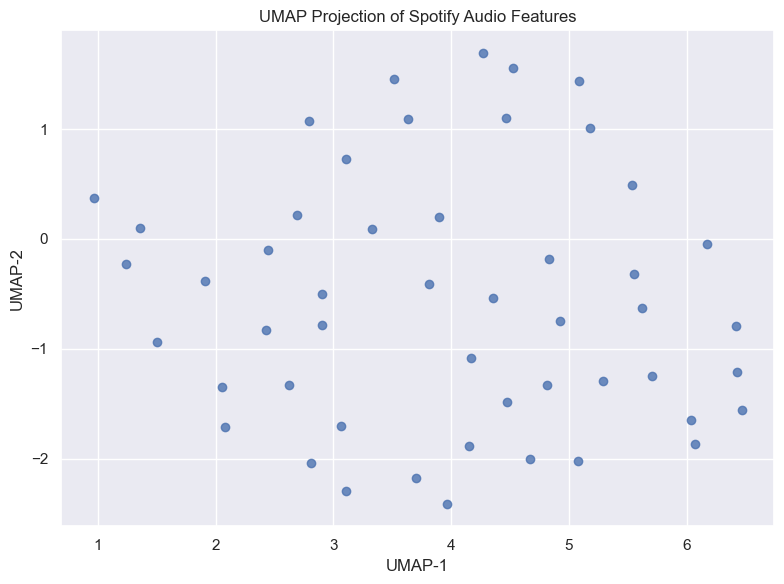

In [22]:
# 5. 🧭 UMAP reduction for visual clarity
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.8)
plt.title("UMAP Projection of Spotify Audio Features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.savefig("../outputs/umap_projection.png")
plt.show()


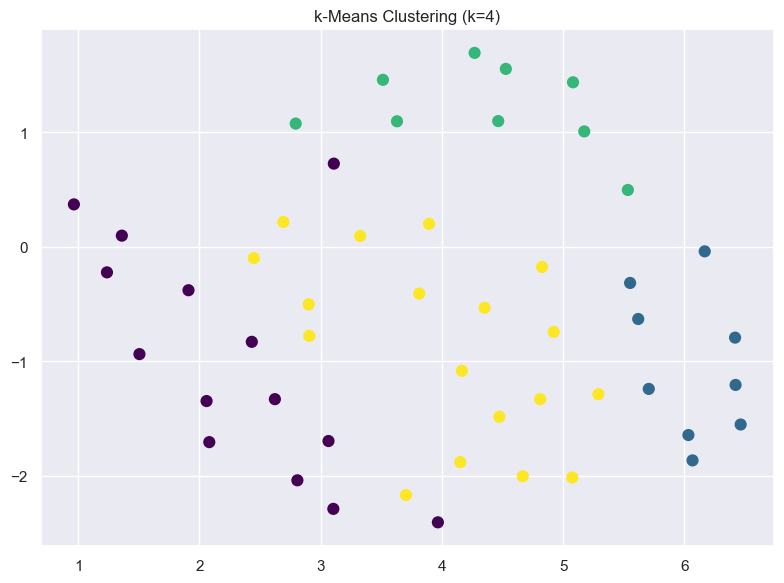

In [23]:
# 6. ⚙️ k-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans_labels, cmap='viridis', s=60)
plt.title("k-Means Clustering (k=4)")
plt.tight_layout()
plt.savefig("../outputs/kmeans_clusters.png")
plt.show()


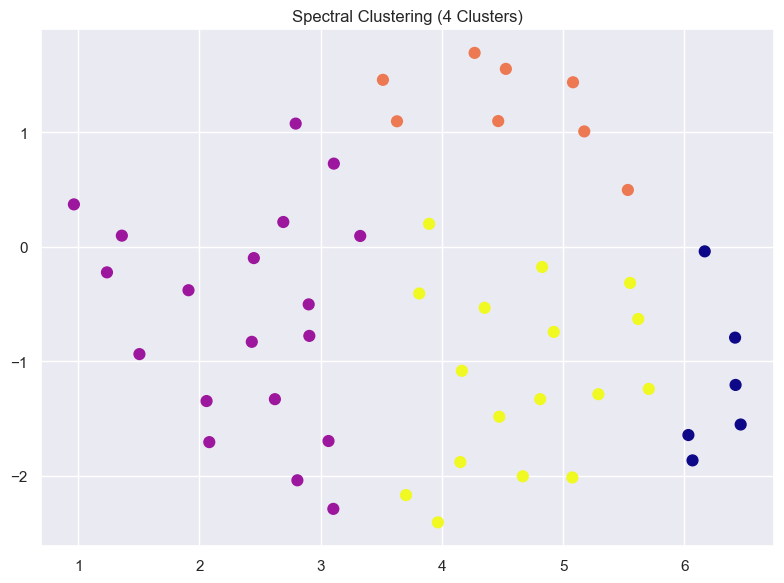

In [24]:
# 7. ⚙️ Spectral Clustering
spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=spectral_labels, cmap='plasma', s=60)
plt.title("Spectral Clustering (4 Clusters)")
plt.tight_layout()
plt.savefig("../outputs/spectral_clusters.png")
plt.show()


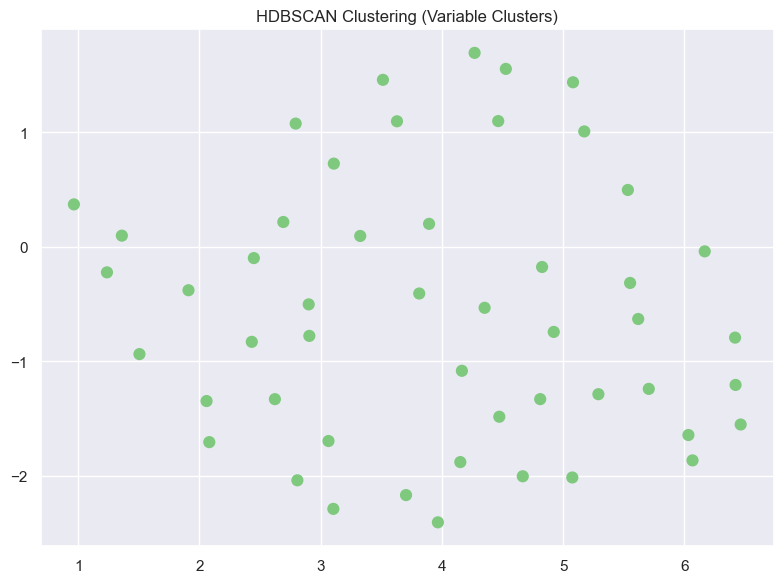

In [25]:
# 8. ⚙️ HDBSCAN (Density-Based)
hdb = hdbscan.HDBSCAN(min_cluster_size=4)
hdb_labels = hdb.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=hdb_labels, cmap='Accent', s=60)
plt.title("HDBSCAN Clustering (Variable Clusters)")
plt.tight_layout()
plt.savefig("../outputs/hdbscan_clusters.png")
plt.show()


In [26]:
# 9. 📏 Evaluate clustering performance
def safe_silhouette(X, labels):
    return silhouette_score(X, labels) if len(set(labels)) > 1 and -1 not in set(labels) else np.nan

scores = {
    'k-Means': safe_silhouette(X_scaled, kmeans_labels),
    'Spectral': safe_silhouette(X_scaled, spectral_labels),
    'HDBSCAN': safe_silhouette(X_scaled, hdb_labels)
}

print("Silhouette Scores:")
for model, score in scores.items():
    print(f"{model}: {score:.3f}")


Silhouette Scores:
k-Means: 0.130
Spectral: 0.153
HDBSCAN: nan


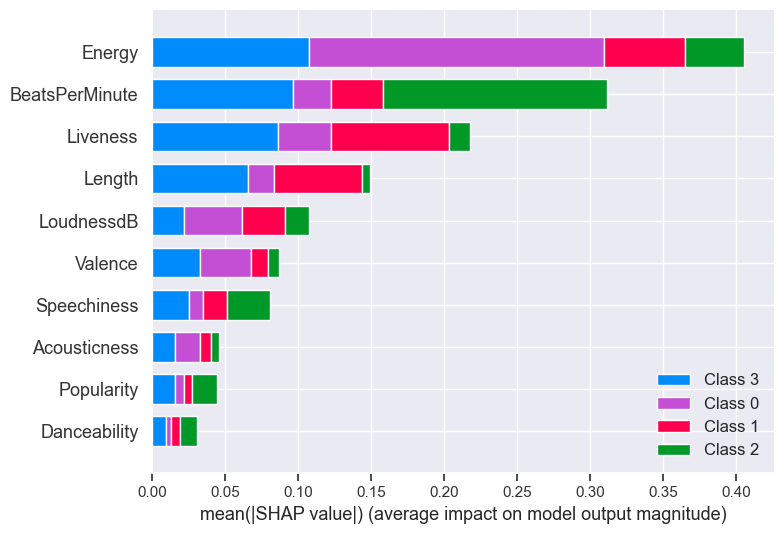

In [27]:
# 10. 🧠 SHAP explanations using k-Means as proxy
from sklearn.ensemble import RandomForestClassifier

shap_model = RandomForestClassifier(n_estimators=100, random_state=42)
shap_model.fit(X_scaled, kmeans_labels)

explainer = shap.Explainer(shap_model, X_scaled)
shap_values = explainer(X_scaled, check_additivity=False)

shap.summary_plot(shap_values, X, plot_type="bar")


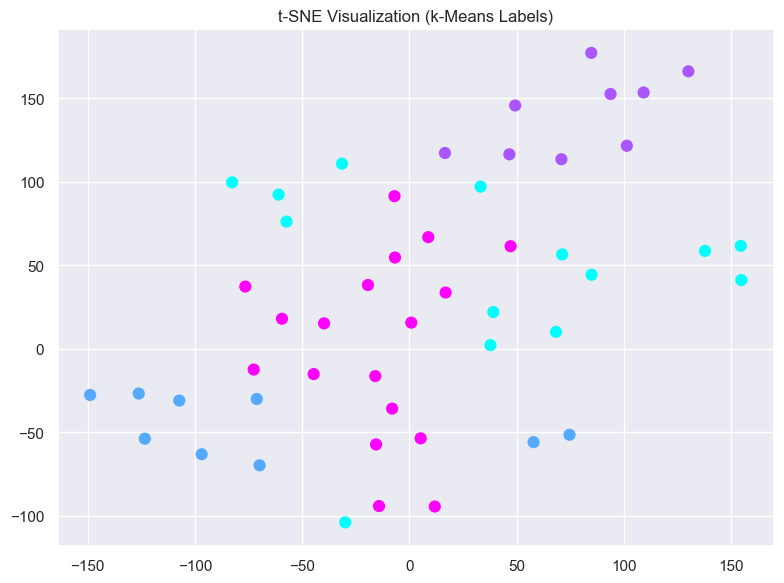

In [28]:
# 11. 🔄 Optional t-SNE if UMAP is too abstract
tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='cool', s=60)
plt.title("t-SNE Visualization (k-Means Labels)")
plt.tight_layout()
plt.savefig("../outputs/tsne_kmeans.png")
plt.show()


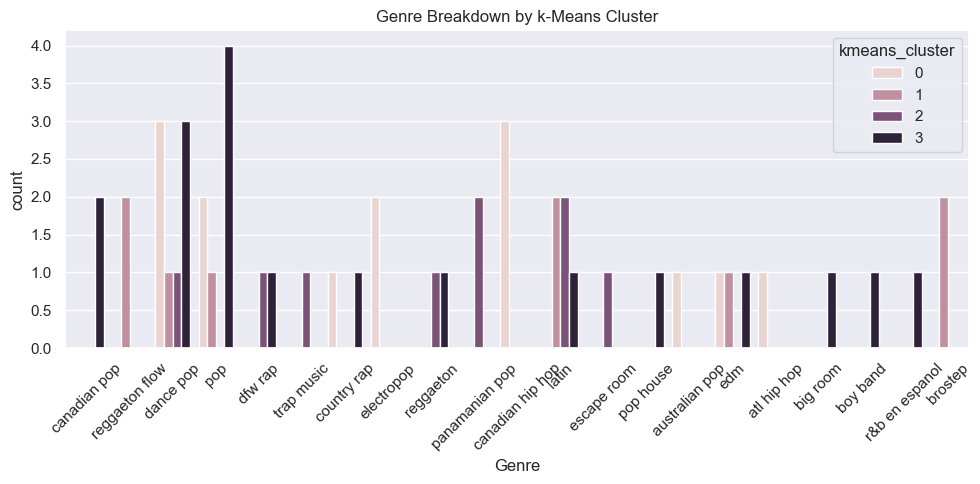

In [29]:
# 12. 🎵 Compare cluster labels to genre
df["kmeans_cluster"] = kmeans_labels
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Genre", hue="kmeans_cluster")
plt.xticks(rotation=45)
plt.title("Genre Breakdown by k-Means Cluster")
plt.tight_layout()
plt.savefig("../outputs/genre_vs_cluster.png")
plt.show()


In [30]:
# 13. 📊 Summary Table
summary = pd.DataFrame({
    "Model": ["k-Means", "Spectral", "HDBSCAN"],
    "Silhouette Score": [
        scores['k-Means'],
        scores['Spectral'],
        scores['HDBSCAN']
    ],
    "Number of Clusters": [
        len(set(kmeans_labels)),
        len(set(spectral_labels)),
        len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
    ]
})

summary


,Model,Silhouette Score,Number of Clusters
0,k-Means,0.129597,4
1,Spectral,0.152799,4
2,HDBSCAN,NaN,0
